## 5. CRISP-DM: Modeling

## Training and Evaluation without SMOTE

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating initial models:


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


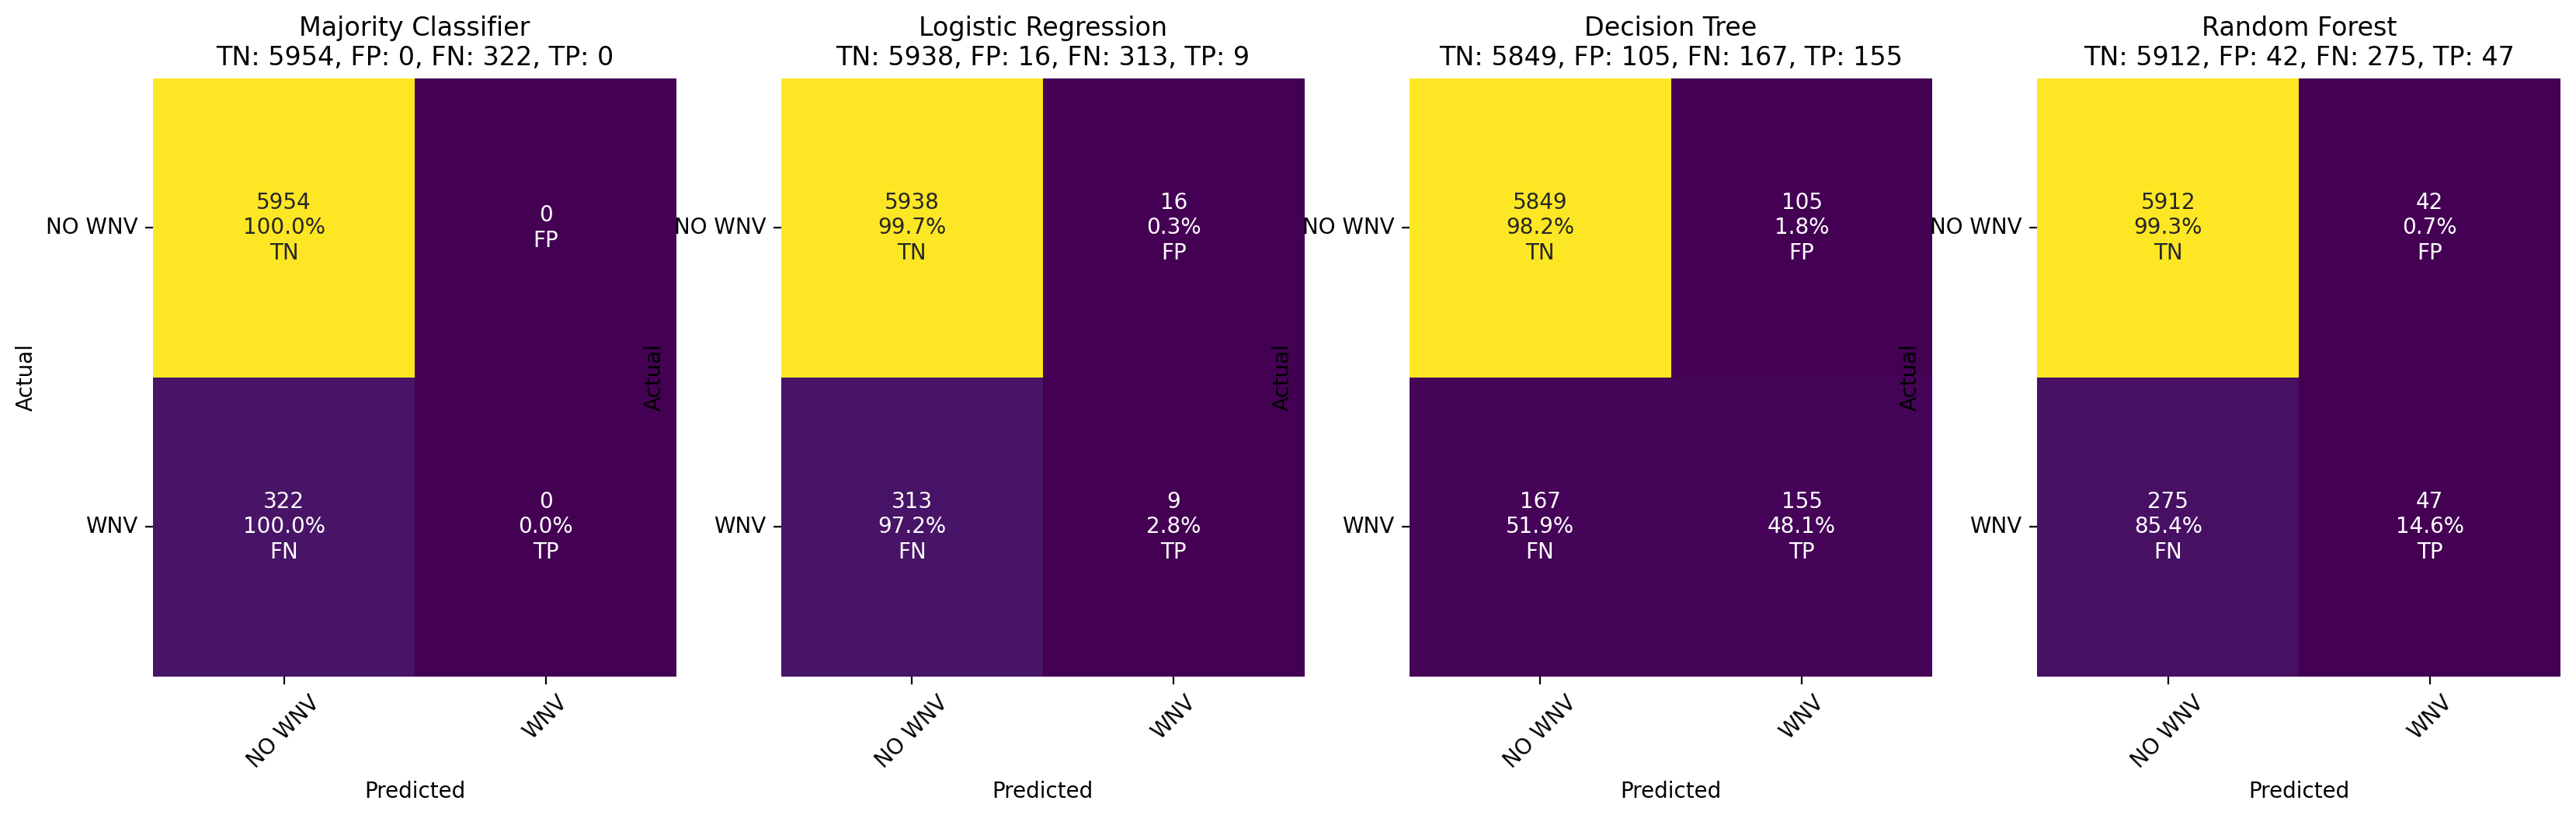

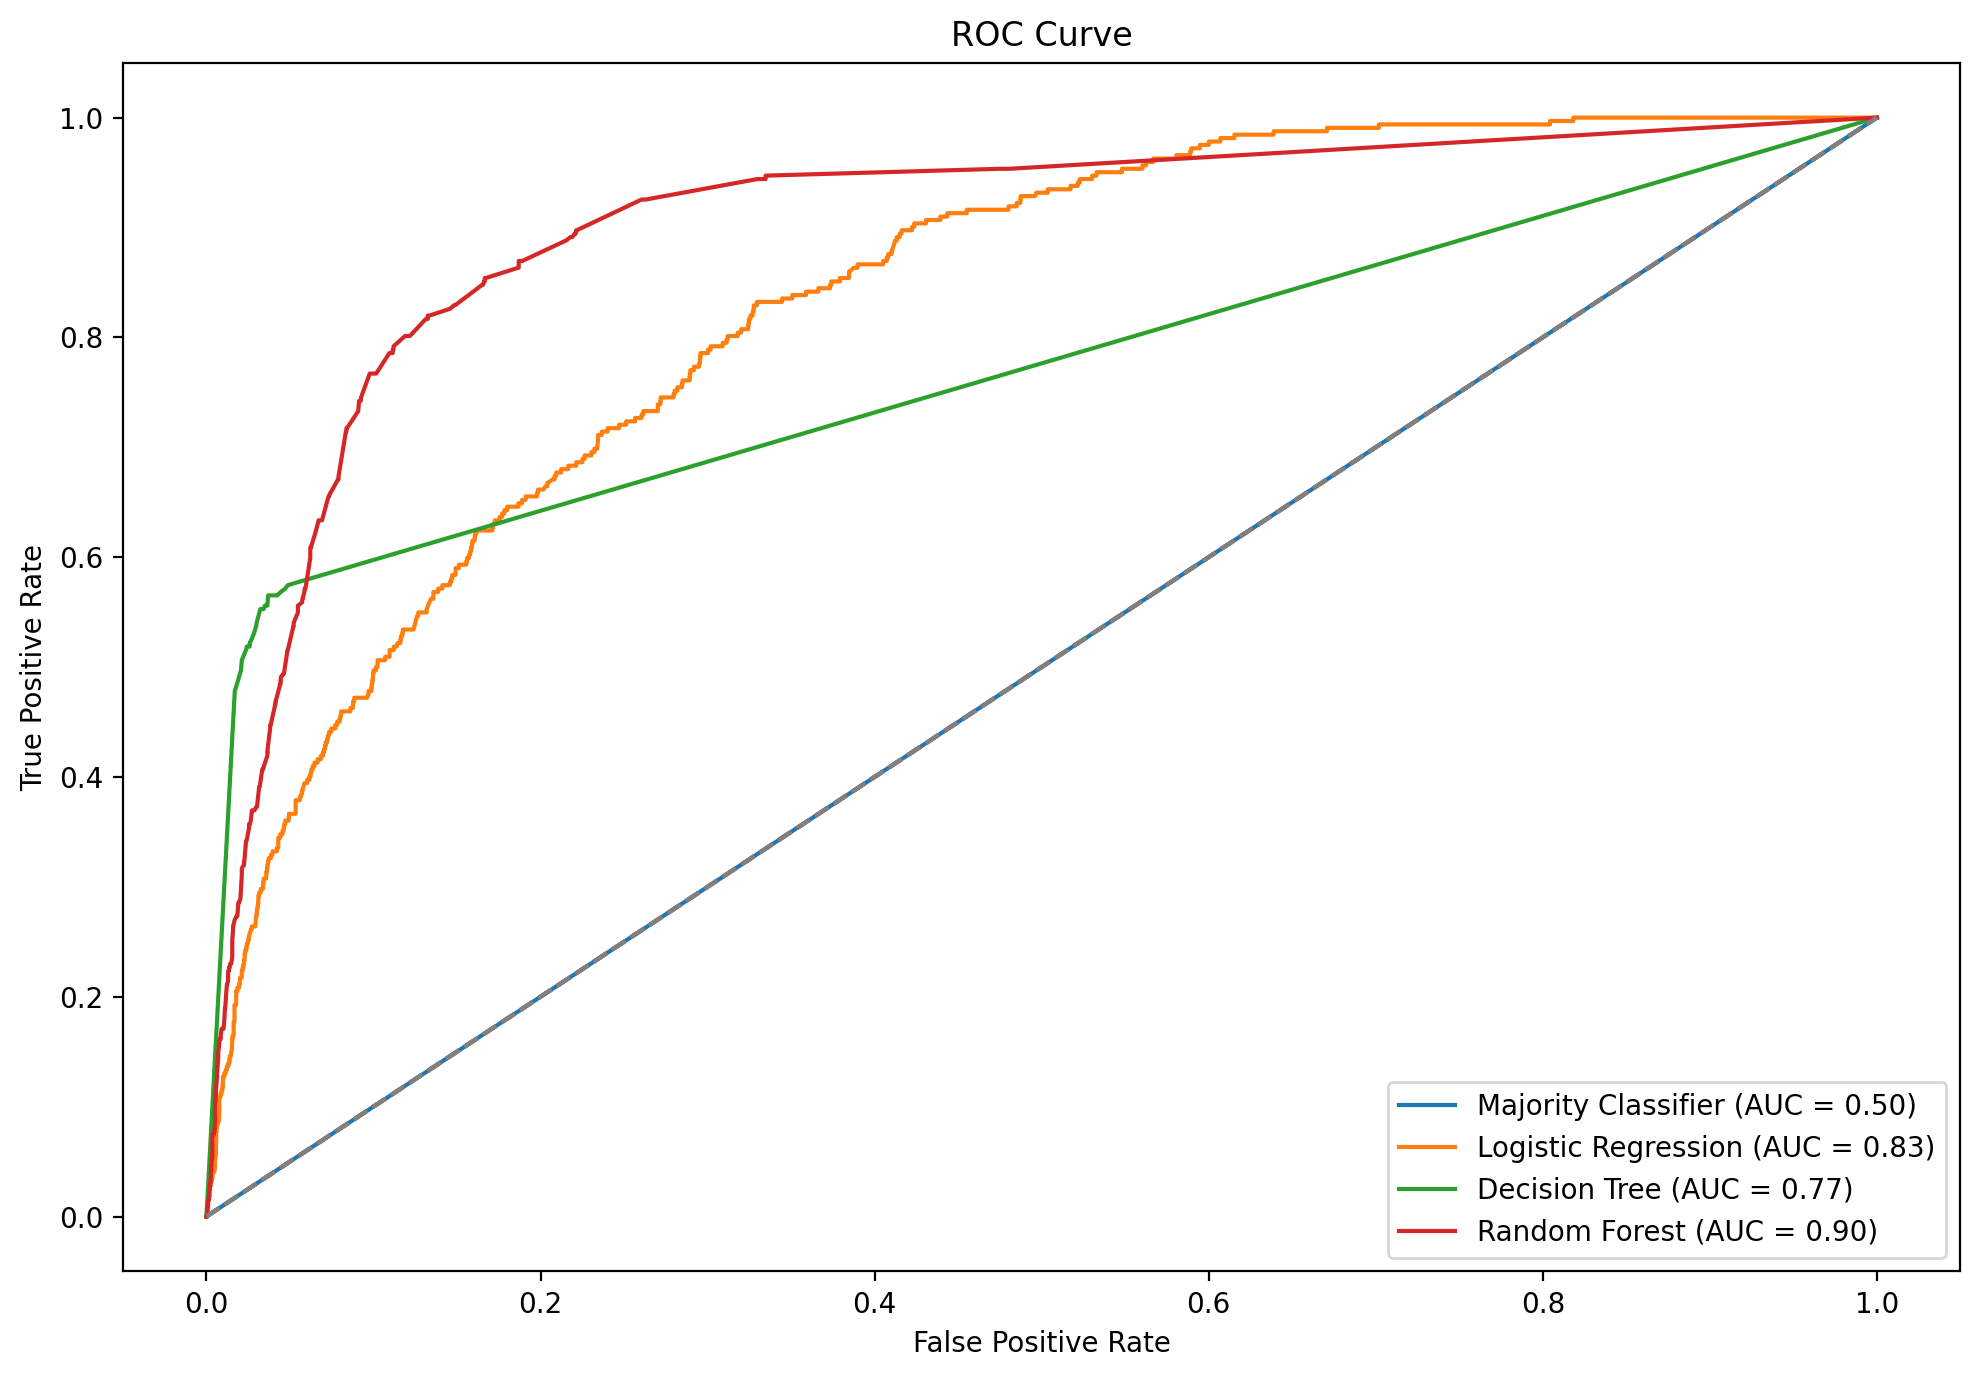

,Accuracy,ROC AUC,F1 Score,Precision,Recall
Majority Classifier,0.948693,0.500000,0.000000,0.000000,0.000000
Logistic Regression,0.947578,0.830959,0.051873,0.360000,0.027950
Decision Tree,0.956660,0.770149,0.532646,0.596154,0.481366
Random Forest,0.949490,0.901765,0.228710,0.528090,0.145963


Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [2]:
#!/usr/bin/env python
# coding: utf-8

# ## 5. CRISP-DM: Modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score
import joblib
import os
from IPython.display import display, Markdown
import seaborn as sns

# Settings for plotting
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'  # High resolution figures")

def prepare_data_for_modeling(train, test):
    # Data preparation
    X = train.drop(["WnvPresent"], axis=1)
    y = train['WnvPresent']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test, test

# Load datasets
train_cleaned = pd.read_csv('../data/cleaned_train.csv')
test_cleaned = pd.read_csv('../data/cleaned_test.csv')

def prepare_models():
    models = {
        'Majority Classifier': DummyClassifier(strategy="most_frequent"),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier()
    }
    return models

def train_models(models, X_train, y_train):
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models

def plot_confusion_matrix(ax, y_true, y_pred, class_names, classifier_name):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = cm[i, j]
            p = cm_perc[i, j]
            s = cm_sum[i]
            if i == j:
                annot[i, j] = f'{c}\n{p:.1f}%\n{"TN" if i == 0 else "TP"}'
            elif c == 0:
                annot[i, j] = f'0\n{"FP" if i == 0 else "FN"}'
            else:
                annot[i, j] = f'{c}\n{p:.1f}%\n{"FP" if i == 0 else "FN"}'

    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(cm_df, annot=annot, fmt='', cmap='viridis', cbar=False, ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(f'{classifier_name}\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticklabels(class_names, rotation=0)

def plot_roc_curve(ax, y_true, y_proba, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    ax.plot(fpr, tpr, label=f'{classifier_name} (AUC = {auc_score:.2f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')

def evaluate_models(trained_models, X_test, y_test, plot_cm=True, plot_roc=True):
    if not trained_models:
        print("No trained models to evaluate.")
        return pd.DataFrame()  # Return an empty DataFrame if no models are provided
    
    results = {}
    class_names = ['NO WNV', 'WNV']
    fig_cm, axes_cm = plt.subplots(1, len(trained_models), figsize=(5 * len(trained_models), 5))
    fig_roc, ax_roc = plt.subplots(figsize=(10, 7))
    
    for i, (name, model) in enumerate(trained_models.items()):
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A',
            'F1 Score': f1_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred)
        }
        
        if plot_cm:
            plot_confusion_matrix(axes_cm[i], y_test, y_pred, class_names, name)
        
        if plot_roc and y_prob is not None:
            plot_roc_curve(ax_roc, y_test, y_prob, name)
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(results).T

def hyperparameter_tuning(models, X_train, y_train):
    
    param_grid = {
        'Logistic Regression': {
            'C': [0.1, 1, 10],  
            'solver': ['liblinear'],  
            'penalty': ['l2']  
        },
        'Decision Tree': {
            'max_depth': [None, 10, 20],  
            'min_samples_split': [2, 10],  
            'min_samples_leaf': [1, 5]  
        },
        'Random Forest': {
            'n_estimators': [100, 200],  
            'max_depth': [None, 10, 20],  
            'min_samples_split': [2, 10],  
            'min_samples_leaf': [1, 5]  
        }
    }
    
    best_models = {}
    for name, model in models.items():
        if name in param_grid:
            grid_search = GridSearchCV(model, param_grid=param_grid[name], cv=3, scoring='roc_auc')
            grid_search.fit(X_train, y_train)
            best_models[name] = grid_search.best_estimator_
            print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    return best_models

def cross_validate_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f'Cross-Validation Scores for {model}: {scores}')
    print(f'Mean CV Score: {np.mean(scores):.2f}')

def main_workflow():
    display(Markdown(f"## Training and Evaluation without SMOTE"))

    # Load datasets
    train_cleaned = pd.read_csv('../data/cleaned_train.csv')
    test_cleaned = pd.read_csv('../data/cleaned_test.csv')
    X_train, X_test, y_train, y_test, test_encoded = prepare_data_for_modeling(train_cleaned, test_cleaned)

    # Prepare and train models
    models = prepare_models()
    trained_models = train_models(models, X_train, y_train)
    
    # Evaluate initial models and display results
    print("Evaluating initial models:")
    results_df = evaluate_models(trained_models, X_test, y_test, plot_cm=True, plot_roc=True)
    display(results_df)  # This will display the evaluation metrics in tabular form

    # Perform hyperparameter tuning and re-train models
    best_models = hyperparameter_tuning(models, X_train, y_train)
    best_trained_models = train_models(best_models, X_train, y_train)
    
    # Evaluate hyperparameter-tuned models and display results
    print("Evaluating hyperparameter-tuned models:")
    best_results_df = evaluate_models(best_trained_models, X_test, y_test, plot_cm=True, plot_roc=True)
    display(best_results_df)  # This will display the evaluation metrics in tabular form

    # Select and cross-validate the best model (adjust as necessary to pick the actual best model)
    if 'Random Forest (estimators=200, depth=20)' in best_trained_models:
        best_model = best_trained_models['Random Forest (estimators=200, depth=20)']
    else:
        best_model = RandomForestClassifier(n_estimators=200, max_depth=20)
        best_model.fit(X_train, y_train)  # Ensure the model is fitted

    cross_validate_model(best_model, X_train, y_train)

    # Create submission CSV using the best model
    test_predictions = best_model.predict_proba(test_encoded)[:, 1]
    test_predictions = np.round(test_predictions, 2)
    submission = pd.DataFrame({
        'Id': test_cleaned['Id'],
        'WnvPresent': test_predictions
    })
    submission.to_csv('submission.csv', index=False)
    print("Submission file created successfully.")

# Run the workflow
main_workflow()


## Confusion Matrix Terminology

- **True Negatives (TN):** The number of instances correctly predicted as not having the condition.
- **True Positives (TP):** The number of instances correctly predicted as having the condition

- **False Positives (FP):** The number of instances incorrectly predicted as having the condition when they do not.
- **False Negatives (FN):** The number of instances incorrectly predicted as not having the condition when they do.
